# __Step 2b: Word2Vec and BERT models__



## __Setup__

### _Imports_

In [67]:
'''
For building text classification model based on embedding of Word2Vec and BERT
'''

## For reproducibility
rand_state = 20220609

## for data
import argparse
import json
import pandas as pd
import numpy as np
import joblib
import pickle
import sys
import matplotlib.pyplot as plt
import seaborn as sns
from os import chdir
from pathlib import Path

## for bag-of-words
from sklearn import feature_extraction, feature_selection, metrics
from sklearn import model_selection
from xgboost import XGBClassifier

In [101]:
## for word embedding with w2v
import gensim

## for deep learning
from tensorflow import keras
from tensorflow.keras import models, layers, callbacks
import tensorflow_addons as tfa

## for bert language model
import transformers

### _Functions_

In [5]:
def read_configs(config_file):
  """Read configuration file and return a config_dict"""
  # required
  config_dict = {'lang_model':0,
                 'proj_dir':0,
                 'work_dir':0,
                 'corpus_combo_file':0,
                 'rand_state':0,
                 'xg_param':0,
                 'n_splits':0,
                 'xg_param_comb':0,
                 'n_jobs':0,}

  # Read config file and fill in the dictionary
  with open(config_file, 'r') as f:
    configs     = f.readlines()
    for config in configs:
      if config.strip() == "" or config[0] == "#":
        pass
      else:
        config = config.strip().split("=")
        if config[0] in config_dict:
          config_dict[config[0]] = eval(config[1])

  # Check if any config missing
  missing = 0
  for config in config_dict:
    if config_dict[config] == 0:
      print("  missing:", config)
      missing += 1
    else:
      print("  ", config, "=", config_dict[config])

  if missing == 0:
    print("  all config available")
  else:
    print("  missing config, QUIT!")
    sys.exit(0)

  return config_dict


def split_train_test(corpus_combo_file, rand_state):
  '''Load data and split train test
  Args:
    corpus_combo_file (str): path to the json data file
    rand_state (int): for reproducibility
  Return:
    train_ori, test_ori, train_cln, test_cln (pandas dataframes): for the
      original and clean texts, training and testing splits.
  '''
  # Load json file
  with corpus_combo_file.open("r+") as f:
      corpus_combo_json = json.load(f)

  # Convert json back to dataframe
  corpus_combo = pd.read_json(corpus_combo_json)

  corpus_ori = corpus_combo[['label','txt']]
  train_ori, test_ori = model_selection.train_test_split(corpus_ori, 
      test_size=0.2, stratify=corpus_ori['label'], random_state=rand_state)

  # Cleaned corpus
  corpus_cln = corpus_combo[['label','txt_clean']]
  corpus_cln.rename(columns={'txt_clean': 'txt'}) # make col names consistent
  train_cln, test_cln = model_selection.train_test_split(corpus_cln, 
      test_size=0.2, stratify=corpus_cln['label'], random_state=rand_state)

  return train_ori, test_ori, train_cln, test_cln


def select_feat(X_train, y_train, vectorizer, p_threshold):
  '''Select features based on chi-square test results
  Args:
    X_train (pandas series): the txt column in the training data frame
    y_train (pandas series): the label column in the training data frame
    vecorizer: fitted with original X_train and returned from get_vectorizer()
    p_threshold (float): p is derived from chi-square test. Features with p <= 
      p_threshold_s are selected.
  Return:
    X_names (list): names of selected features
  '''
  y            = y_train
  X_names      = vectorizer.get_feature_names_out()
  dtf_features = pd.DataFrame()
  for cat in np.unique(y):
    _, p = feature_selection.chi2(X_train, y==cat)
    dtf_features = pd.concat([dtf_features, 
                pd.DataFrame({"feature":X_names, "p":p, "y":cat})])
    dtf_features = dtf_features.sort_values(
                ["y","p"], ascending=[True,False])
    dtf_features = dtf_features[dtf_features["p"] <= p_threshold]
  
  X_names = dtf_features["feature"].unique().tolist()

  return X_names


def run_xgboost(X_train, y_train, config_dict):
  '''Do hyperparameter tuning and cross-validation of XgBoost models
  Args:
    X_train (pandas dataframe): features
    y_train (pandas series): labels
    config_dict (dict): from read_config()
  Return:
    rand_search (RandomizedSearchCV): fitted obj
  '''

  rand_state = config_dict["rand_state"]
  param_grid = config_dict["xg_param"] 
  n_splits   = config_dict["n_splits"]
  param_comb = config_dict["xg_param_comb"]
  n_jobs     = config_dict["n_jobs"]

  # Initialize classifier
  # 06/11/2022: the silent parameter is deprecated, use verbosity=0
  xgb = XGBClassifier(learning_rate=0.02, 
                      n_estimators=600, 
                      objective='binary:logistic',
                      verbosity=1, 
                      nthread=1)
  # Initilize stratified k fold obj
  skf = model_selection.StratifiedKFold(n_splits=n_splits, 
                      shuffle = True, random_state = rand_state)
  # initiate randomized search CV obj
  rand_search = model_selection.RandomizedSearchCV(
                      xgb                , param_distributions = param_grid, 
                      n_iter = param_comb, scoring      = 'f1', 
                      n_jobs = n_jobs    , cv = skf.split(X_train,y_train), 
                      verbose = 3        , random_state =rand_state)
  # Train
  rand_search.fit(X_train, y_train)

  return rand_search


def run_main_function(work_dir, train, test, txt_flag, config_dict):

  # Get the training/testing corpus and labels
  if txt_flag == "ori":
    X_train = train['txt']
    X_test  = test['txt']
  else:
    X_train = train['txt_clean']
    X_test  = test['txt_clean']

  y_train = train['label']
  y_test  = test['label']

  # get vectorizer parameter list
  p_threshold = config_dict['p_threshold']
  param_list  = get_hyperparameters(config_dict['vec_param'], p_threshold)
  lang_model  = config_dict['lang_model']

  # iterate through different parameters
  with open(work_dir / f"scores_{txt_flag}", "w") as f:
    f.write("run\ttxt_flag\tlang_model\tparameters\tnum_feat\tcv_f1\t" +\
            "test_f1\tmodel_name\n")
    run_num = 0
    for param in param_list:
      print(f"\n## param: {param}")
      best_score, num_select, model_name, test_score = run_pipeline(
        work_dir, X_train, y_train, X_test, y_test, param, txt_flag, config_dict)

      f.write(f"{run_num}\t{txt_flag}\t{lang_model}\t{str(param)}\t"+\
              f"{num_select}\t{best_score}\t{test_score}\t{model_name}\n")

      run_num += 1


def run_pipeline(work_dir, X_train, y_train, X_test, y_test, param, txt_flag,
                 config_dict):
  '''Carry out the major steps'''

  # Get vectorizer and fitted X_train
  print("  extract features by fitting a vectorizer")
  lang_model = config_dict['lang_model']
  vectorizer, X_train_vec = extract_feat(X_train, param, lang_model)
  print("    train dim:", X_train_vec.shape)

  # Get selected feature names
  print("  select features")
  p_threshold = config_dict['p_threshold']
  X_names     = select_feat(X_train_vec, y_train, vectorizer, p_threshold)
  num_select  = len(X_names)
  print('    total selected:', num_select)

  # Refit vectorizer with selected features and re-transform X_train
  print("  refit vectorizer with training data and transform")
  vectorizer_sel, X_train_vec_sel = extract_feat(X_train, vocab=X_names)
  print("    train dim:", X_train_vec_sel.shape)

  # Also apply the refitted vecorizer to testing data
  print("  transform testing data")
  X_test_vec_sel = vectorizer_sel.transform(X_test)
  print("    test dim:", X_test_vec_sel.shape)

  # Get xgboost model and cv results
  print("  cross-validation and tuning with xgboost")
  rand_search = run_xgboost(X_train_vec_sel, y_train, config_dict)

  best_est   = rand_search.best_estimator_
  best_param = rand_search.best_params_
  best_score = rand_search.best_score_
  print("    best F1:", best_score)
  print("    best param:", best_param)

  # Save the best model
  print ("  save model")
  param_str  = \
      f"{int(param[0])}-{'to'.join(map(str,param[1]))}-{param[2]}"

  model_name = work_dir / f'model_{txt_flag}_{param_str}.sav'
  joblib.dump(best_est, model_name)

  # Get testing results: This is not for tuning/selection purpose but because
  # X_test is transformed by vectorizer for each parameter combination. If
  # the testing set is not evaluated now, things just get too complicated.
  # Keep in mind that the testing F1s will not be compared against each other.
  print("  get testing f1")
  y_pred = best_est.predict(X_test_vec_sel)
  test_score = metrics.f1_score(y_test, y_pred)

  # provide some space between runs
  print('\n')

  return best_score, num_select, model_name, test_score

### _Get training/testing split_

In [8]:
config_file = Path("config_w2v_bert.txt")

print("\nRead configuration file...")
config_dict = read_configs(config_file)

# Set up working directory and corpus file location
proj_dir          = Path(config_dict['proj_dir'])
work_dir          = proj_dir / config_dict['work_dir']
corpus_combo_file = work_dir / config_dict['corpus_combo_file']

# For reproducibility
rand_state = config_dict['rand_state']

# Split train/test for original and cleaned text
print("\nRead file and split train/test...")
train_ori, test_ori, train_cln, test_cln = split_train_test(
                                              corpus_combo_file, rand_state)


Read configuration file...
   lang_model = w2v
   proj_dir = /home/shinhan/projects/plant_sci_hist
   work_dir = 2_text_classify
   corpus_combo_file = corpus_combo
   rand_state = 20220609
   xg_param = {'min_child_weight': [1, 5, 10], 'gamma': [0.5, 1, 1.5, 2, 5], 'subsample': [0.6, 0.8, 1.0], 'colsample_bytree': [0.6, 0.8, 1.0], 'max_depth': [3, 4, 5]}
   n_splits = 5
   xg_param_comb = 5
   n_jobs = 12
  all config available

Read file and split train/test...


## __Word2Vec-based model__

06/14/22: After tryng to implement this for my own project, realize there are some major issues:
1. Bi- and tri-grams were obtained. But not used in the example code.
2. The word vectors were used 

### _Testing with cleaned text_

Starting out, I was testing with the original text. When looking into most similar words to "jasmonate" there are substantial issue. Top 20 most similar:

````Python
[('(MeJA)', 0.7294234037399292), ('jasmonic', 0.6400792002677917), ('methyl', 0.638791024684906), ('JA', 0.6380835175514221), ('(JA)', 0.6271078586578369), ('(MeJA),', 0.6264932155609131), ('jasmonate,', 0.6005000472068787), ('(MeJA).', 0.5945847034454346), ('ZIM-domain', 0.5596743226051331), ('jasmonate-', 0.5553220510482788), ('salicylic', 0.5499346256256104), ('JA-isoleucine', 0.5474823713302612), ('12-oxophytodienoic', 0.5435537099838257), ('aminocyclopropane', 0.542698860168457), ('methyl-jasmonate', 0.5406786799430847), ('methyljasmonate', 0.5398091077804565), ('wounding', 0.5363242030143738), ('jasmonate..', 0.5355076789855957), ('acid-isoleucine', 0.531741738319397), ('(MeSA)', 0.5283530950546265)]
```

So for the next test run repeat and the real run, only cleaned text is used.

#### Get uni-, bi-, and tri-grams

In [9]:
# Fit my own Word2Vec model with my corpus
corpus = train_cln['txt_clean'] # pandas Series
type(corpus), corpus[:2]

(pandas.core.series.Series,
 853778     update exertional hyponatremia active componen...
 1165206    stable megadalton toctic supercomplexes major ...
 Name: txt_clean, dtype: object)

In [10]:
## create list of lists of unigrams
lst_corpus = []
for string in corpus:

   # Q: lst_words and lst_grams are the same, what's the point?
   lst_words = string.split()
   
   #lst_grams = [" ".join(lst_words[i:i+1]) 
   #            for i in range(0, len(lst_words), 1)]
   #lst_corpus.append(lst_grams)

   lst_corpus.append(lst_words)
print(lst_corpus[0][:20])

['update', 'exertional', 'hyponatremia', 'active', 'component', 'u', 'armed', 'force', '19992012', '1999', '2012', '1333', 'incident', 'diagnosis', 'exertional', 'hyponatremia', 'among', 'active', 'component', 'member']


In [11]:
## detect bigrams and trigrams

bigrams_detector  = gensim.models.phrases.Phrases(lst_corpus, 
                                                  delimiter=" ", 
                                                  min_count=5, 
                                                  threshold=10)
bigrams_detector  = gensim.models.phrases.Phraser(bigrams_detector)

In [12]:
# Note that the input the trigrams_detector is output of the bigrams_detector
trigrams_detector = gensim.models.phrases.Phrases(bigrams_detector[lst_corpus], 
                                                  delimiter=" ", 
                                                  min_count=5, 
                                                  threshold=10)
trigrams_detector = gensim.models.phrases.Phraser(trigrams_detector)

#### _Initialize Word2Vec model_

- `sequences`: lst_corpus
- `vector_size`: dimension of word embeddings
- `window`: max distance between the current and the predicted words in a sentence
- `min_count`: ignore all words with total frquency lower than this.
  - [Discussion on seeting min_count](https://stackoverflow.com/questions/50723303/how-is-word2vec-min-count-applied)
- `sg`: history algorithm, 1: skip-gram, otherwise CBOW.

Following [this](https://www.kaggle.com/code/pierremegret/gensim-word2vec-tutorial/notebook).

In [13]:
model_w2v = gensim.models.Word2Vec(vector_size=300, window=8, 
                                   min_count=20, sg=1, epochs=30, workers=16,
                                   seed=rand_state)

In [14]:
# Building the Vocabulary Table
model_w2v.build_vocab(lst_corpus, progress_per=10000)

In [15]:
# Train w2v model
model_w2v.train(lst_corpus, total_examples=model_w2v.corpus_count, epochs=30,
                report_delay=1)

(266210970, 294780990)

In [17]:
# Save the w2v model
with open(work_dir / "model_cln_w2v", "wb") as f:
    pickle.dump(model_w2v, f)

In [18]:
# Testing the w2v model
# Here there is problem with stop words. Like 'jasmonate..', '(MeJA)', and other
# variants. So should use the cleaned text.
example = "jasmonate"
print(len(model_w2v.wv[example]))
print(model_w2v.wv.most_similar(example, topn=20))

300
[('ja', 0.6890448331832886), ('jasmonic', 0.6880596280097961), ('meja', 0.6707953810691833), ('methyl', 0.6292332410812378), ('zimdomain', 0.6150268316268921), ('salicylic', 0.5850669741630554), ('jasmonates', 0.5643168091773987), ('wounding', 0.5591111183166504), ('jaile', 0.545391321182251), ('abscisic', 0.5396086573600769), ('ethylene', 0.5352954864501953), ('jaresponsive', 0.5283914804458618), ('jamediated', 0.5222938060760498), ('jaz', 0.5193976759910583), ('jadependent', 0.5175454020500183), ('myc2', 0.5140773057937622), ('phytohormone', 0.5132154226303101), ('pdf12', 0.5060152411460876), ('coronatine', 0.5018571615219116), ('aba', 0.5010020732879639)]


#### _Train tokenizer_

In [19]:
# intialize tokenizer
tokenizer = keras.preprocessing.text.Tokenizer(
                        lower=True, 
                        split=' ', 
                        oov_token="NaN", 
                        filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')

# tokenize corpus 
tokenizer.fit_on_texts(lst_corpus)

# get token dictionary, with token as key, index number as value
dic_vocab_token = tokenizer.word_index

#### _Turn texts into index numbers_

Transforms each text in texts to a sequence of integers.

In [20]:
lst_text2seq = tokenizer.texts_to_sequences(lst_corpus)
print(lst_corpus[0][:10])
print(lst_text2seq[0][:10])

['update', 'exertional', 'hyponatremia', 'active', 'component', 'u', 'armed', 'force', '19992012', '1999']
[3809, 22571, 17330, 285, 181, 562, 13332, 1316, 152030, 4721]


In [22]:
# The index numbers are the values from the token dictionary
# Note that these are lowercased
dic_vocab_token['update'], dic_vocab_token['exceptional']

(3809, 8510)

#### _Check min, max, avg len_

In [ ]:
### NOT Run ###
'''
minlen = 100; maxlen = 0; totlen = 0
lst_0  = []   # index of sequences with zero lengths

for idx in tqdm(range(len(lst_text2seq))):
    slen   = len(lst_text2seq[idx])
    totlen +=slen
    if slen > maxlen: maxlen = slen
    if slen < minlen: 
        if slen == 0: lst_0.append(idx)
        else: minlen = slen
print(f'Min:{minlen}, Max:{maxlen}, Avg:{totlen/len(lst_text2seq)}')
print('Zero length:', lst_0)
'''

#### _Pad or trucate sequences_

In [23]:
X_train_w2v = keras.preprocessing.sequence.pad_sequences(
                    lst_text2seq,      # List of sequences, each a list of ints 
                    maxlen=500,         # maximum length of all sequences
                    padding="post",    # 'pre' or 'post' 
                    truncating="post") # remove values from sequences > maxlen
X_train_w2v.shape

(69316, 500)

#### _Create embedding matrix_

In [25]:
## start the matrix (length of vocabulary x vector size) with all 0s

embeddings = np.zeros((len(dic_vocab_token)+1, 300))
not_in_emb = {}
for word, idx in dic_vocab_token.items():
    ## update the row with vector
    try:
        embeddings[idx] =  model_w2v.wv[word]
    ## if word not in model then skip and the row stays all 0s
    except KeyError:
        not_in_emb[word] = 1

len(not_in_emb) # Q: How did this got into the corpus??

305941

#### _Set up ANN_

The model contains:
- An embedding layer:
  - Sequences as input (15 tokens, including padding)
  - Word (embedding?) vectors as weights (what??)
  - Embedding as output (15x300).
- An attention layer
  - Capture the eughts of each instance for building an explaniner.
  - Not needed for the predictions.
- Two layers of bidirectional LSTM.
- Two final dense layer to predict probabilities of classes

In [119]:
def get_w2v_emb_model(embeddings):

    ## code attention layer
    def attention_layer(inputs, neurons):
        x = layers.Permute((2,1))(inputs)
        x = layers.Dense(neurons, activation="softmax")(x)
        x = layers.Permute((2,1), name="attention")(x)
        x = layers.multiply([inputs, x])
        return x

    ## input
    x_in = layers.Input(shape=(500,)) ## embedding
    x = layers.Embedding(input_dim=embeddings.shape[0],  
                        output_dim=embeddings.shape[1], 
                        weights=[embeddings],
                        input_length=500, trainable=False)(x_in)

    ## apply attention
    x = attention_layer(x, neurons=500)

    ## 2 layers of bidirectional lstm
    x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2, 
                            return_sequences=True))(x)
    x = layers.Bidirectional(layers.LSTM(units=15, dropout=0.2))(x)

    ## final dense layers
    x = layers.Dense(64, activation='relu')(x)
    y_out = layers.Dense(2, activation='softmax')(x)

    ## Initialize and compile model
    model = models.Model(x_in, y_out)
    model.compile(loss='sparse_categorical_crossentropy',
                  optimizer='adam', 
                  metrics=['accuracy'])

    return model


In [124]:
model_emb = get_w2v_emb_model(embeddings)
model_emb.summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_10 (InputLayer)          [(None, 500)]        0           []                               
                                                                                                  
 embedding_9 (Embedding)        (None, 500, 300)     99395400    ['input_10[0][0]']               
                                                                                                  
 permute_9 (Permute)            (None, 300, 500)     0           ['embedding_9[0][0]']            
                                                                                                  
 dense_23 (Dense)               (None, 300, 500)     250500      ['permute_9[0][0]']              
                                                                                            

#### _Convert text labels to numeric ones_

In [121]:
## encode y
#  This is the class label, not sure why inversse is done
y_train       = train_cln['label']
dic_y_mapping = {n:label for n,label in enumerate(np.unique(y_train))}
inverse_dic   = {v:k for k,v in dic_y_mapping.items()}
inverse_dic

{0: 0, 1: 1}

In [122]:
# Convert text labels to numeric ones.
#y_train_label = np.array([inverse_dic[y] for y in y_train])
y_train_label = y_train
X_train_w2v.shape, len(y_train_label)

((69316, 500), 69316)

#### _Train model_

In [125]:
## train
callback = callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model_emb.fit(x=X_train_w2v, y=y_train_label, batch_size=256, 
                        epochs=20, shuffle=True, verbose=1, 
                        validation_split=0.3, callbacks=[callback])

Epoch 1/20
190/190 [==============================] - 53s 260ms/step - loss: 0.3293 - accuracy: 0.8437 - val_loss: 0.1423 - val_accuracy: 0.9484
Epoch 2/20
190/190 [==============================] - 49s 256ms/step - loss: 0.1289 - accuracy: 0.9545 - val_loss: 0.1333 - val_accuracy: 0.9520
Epoch 3/20
190/190 [==============================] - 49s 256ms/step - loss: 0.1188 - accuracy: 0.9586 - val_loss: 0.1301 - val_accuracy: 0.9522
Epoch 4/20
190/190 [==============================] - 49s 256ms/step - loss: 0.1129 - accuracy: 0.9607 - val_loss: 0.1285 - val_accuracy: 0.9516
Epoch 5/20
190/190 [==============================] - 49s 256ms/step - loss: 0.1089 - accuracy: 0.9623 - val_loss: 0.1136 - val_accuracy: 0.9614
Epoch 6/20
190/190 [==============================] - 49s 256ms/step - loss: 0.1038 - accuracy: 0.9640 - val_loss: 0.1114 - val_accuracy: 0.9631
Epoch 7/20
190/190 [==============================] - 43s 229ms/step - loss: 0.0999 - accuracy: 0.9661 - val_loss: 0.1226 - val_ac

In [126]:
# Save model
model_emb.save('model_cln_w2v_dnn.h5')

In [145]:
help(model_emb)

Help on Functional in module keras.engine.functional object:

class Functional(keras.engine.training.Model)
 |  Functional(inputs, outputs, name=None, trainable=True, **kwargs)
 |  
 |  A `Functional` model is a `Model` defined as a directed graph of layers.
 |  
 |  Three types of `Model` exist: subclassed `Model`, `Functional` model,
 |  and `Sequential` (a special case of `Functional`).
 |  In general, more Keras features are supported with `Functional`
 |  than with subclassed `Model`s, specifically:
 |  
 |  - Model cloning (`keras.models.clone`)
 |  - Serialization (`model.get_config()/from_config`, `model.to_json()`
 |  - Whole-model saving (`model.save()`)
 |  
 |  A `Functional` model can be instantiated by passing two arguments to
 |  `__init__`. The first argument is the `keras.Input` Tensors that represent
 |  the inputs to the model. The second argument specifies the output
 |  tensors that represent the outputs of this model. Both arguments can be a
 |  nested structure o

In [144]:
type(model_emb)

keras.engine.functional.Functional

#### _Plot loss and accuracy_


In [110]:
his_keys = history.history.keys()
his_keys

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

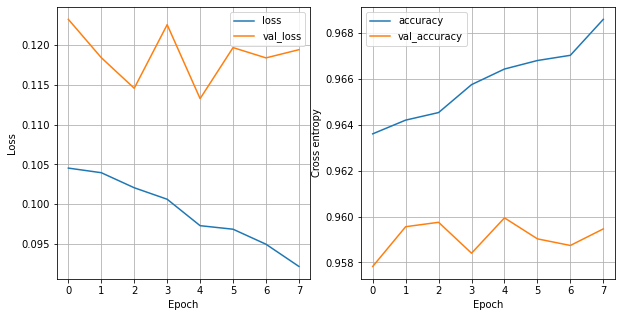

In [111]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
df_history_loss = pd.DataFrame(history.history)[['loss','val_loss']]
df_history_loss.plot(ax=ax1)
df_history_accu = pd.DataFrame(history.history)[['accuracy','val_accuracy']]
df_history_accu.plot(ax=ax2)
ax1.grid(True); ax1.set_xlabel('Epoch'); ax1.set_ylabel('Loss')
ax2.grid(True); ax2.set_xlabel('Epoch'); ax2.set_ylabel('Cross entropy')
plt.show()

#### _Get prediction f1_

In [113]:
y_train_pred_prob = model_emb.predict(X_train_w2v)

In [114]:
y_train_pred = [dic_y_mapping[np.argmax(pred)] for pred in y_train_pred_prob]

In [115]:
metrics.f1_score(y_train_label, y_train_pred)

0.967606131242495

#### _Evaluate model_

In [116]:
## Create list of n-grams for test set
X_test = test_cln['txt_clean']
y_test = test_cln['label']

lst_corpus_test = []
for text in X_test:
    lst_words = text.split()
    lst_corpus_test.append(lst_words)

## Detect common bigram and trigram with fitted detectors
lst_corpus_test_bi = list(bigrams_detector[lst_corpus_test])
lst_corpus_test_tr = list(trigrams_detector[lst_corpus_test_bi])

len(lst_corpus_test_bi), len(lst_corpus_test_tr)

(17330, 17330)

In [117]:
## text to sequence with the fitted tokenizer
lst_text2seq_test = tokenizer.texts_to_sequences(lst_corpus_test_tr)

## padding sequence
X_test_w2v = keras.preprocessing.sequence.pad_sequences(lst_text2seq_test, 
                                maxlen=500, padding="post", truncating="post")
X_test_w2v.shape

(17330, 500)

In [118]:
y_pred_prob_w2v = model_emb.predict(X_test_w2v)

In [75]:
y_pred_prob_w2v[1:4,] # Why are there 3 columns??

array([[9.35286939e-01, 6.47101253e-02, 3.04628588e-06],
       [9.80341971e-01, 1.96567010e-02, 1.33280582e-06],
       [9.99526501e-01, 4.73426946e-04, 1.18548996e-07]], dtype=float32)

In [76]:
# q: Why use dic_y_mapping instead of inverse_dic???
y_pred_w2v      = [dic_y_mapping[np.argmax(pred)] for pred in y_pred_prob_w2v]

In [79]:
test_score = metrics.f1_score(y_test, y_pred_w2v)
print(test_score)

0.9314693634741226


# __NOT USED__

In [ ]:
## evaluation
def eval_model(y_test, y_pred, y_pred_prob, plot_auc=1):
    
    classes = np.unique(y_test)

    # pd.get_dummies: Convert categorical variable into dummy/indicator 
    # variables.
    y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
    ## Accuracy, Precision, Recall
    #accuracy = metrics.accuracy_score(y_test, y_pred)
    auc = metrics.roc_auc_score(y_test, y_pred_prob[:, 1])
    #print("Accuracy:",  round(accuracy,2))
    print("Auc:", round(auc,2))
    print("Detail:")
    print(metrics.classification_report(y_test, y_pred))
        
    ## Plot confusion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)
    _, ax = plt.subplots()
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
                cbar=False)
    ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
        yticklabels=classes, title="Confusion matrix")
    plt.yticks(rotation=0)

    # Setup subplots
    if plot_auc:
        _, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,5))

        ## Plot roc
        for i in range(len(classes)):
                fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                                y_pred_prob[:,i])
                ax[0].plot(fpr, tpr, lw=3, 
                        label='{0} (area={1:0.2f})'.format(classes[i], 
                                        metrics.auc(fpr, tpr))
                        )
        ax[0].plot([0,1], [0,1], color='navy', lw=2, linestyle='--')
        ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
                xlabel='False Positive Rate', 
                ylabel="True Positive Rate (Recall)", 
                title="Receiver operating characteristic")
        ax[0].legend(loc="lower right")
        ax[0].grid(True)
                
        ## Plot precision-recall curve
        for i in range(len(classes)):
                precision, recall, thresholds = metrics.precision_recall_curve(
                        y_test_array[:,i], y_pred_prob[:,i])
                ax[1].plot(recall, precision, lw=3, 
                        label='{0} (area={1:0.2f})'.format(classes[i], 
                                        metrics.auc(recall, precision))
                        )
        ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
                ylabel="Precision", title="Precision-Recall curve")
        ax[1].plot([0,1], [1/3,1/3], color='navy', lw=2, linestyle='--')
        ax[1].legend(loc="best")
        ax[1].grid(True)
        plt.show()

Auc: 0.98
Detail:
              precision    recall  f1-score   support

           0       0.91      0.96      0.94      8665
           1       0.96      0.90      0.93      8665

    accuracy                           0.93     17330
   macro avg       0.94      0.93      0.93     17330
weighted avg       0.94      0.93      0.93     17330



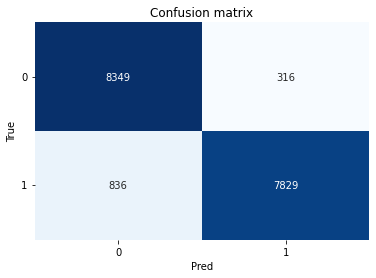

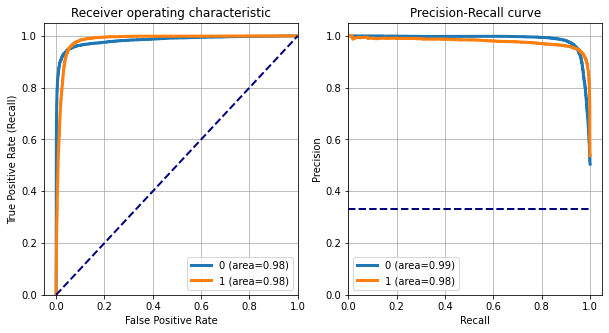

In [77]:
eval_model(y_test, y_pred_w2v, y_pred_prob_w2v, 1)